#### Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tools import FeatureEngineer
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torchvision import datasets, models, transforms

#### Load Data

In [2]:
bnb = pd.read_csv('bnb.csv') # load data
bnb = bnb.sample(n=50000, replace=False, random_state=1)
tool = FeatureEngineer()
bnb = tool.build_technical_indicators(bnb) # construct technical indicators
bnb.drop(columns=['Asset_ID', 'KAMA', 'PSAR+', 'PSAR-'], inplace=True) # drop columns with too many NAs
bnb.dropna(axis=0, inplace=True) # drop rows contain missing
r = bnb.index[np.isinf(bnb).any(1)]
bnb.drop([i for i in r], axis=0, inplace=True) # drop rows contain infinity

In [3]:
train, test = train_test_split(bnb, test_size=0.2) # split train and test
print(f"Training data size: {train.shape}",
      f"Validation data size: {test.shape}")

Training data size: (39840, 75) Validation data size: (9961, 75)


#### Hyperparameters

In [4]:
SEQ_LENGTH    = 60
TARGET        = 'Target'
FEATURES      = [feature for feature in bnb.columns if feature not in TARGET]
BATCH_SIZE    = 5
NUM_FEATURES  = len(FEATURES)
HIDDEN_SIZE   = 50
NUM_LAYERS    = 2
OUTPUT_SIZE   = 1
DROPOUT       = 0.2
LEARNING_RATE = 0.0001

#### Dataset

In [5]:
class CryptoDataset(Dataset):
    
    # data loading
    def __init__(self, data, seq_length, features, target):

        self.data = data
        self.target = target
        self.features = features
        self.seq_length = seq_length
        self.data_length = len(data)
    
        self.metrics = self.create_pairs()
    
    def __getitem__(self, index):
        return self.metrics[index]
        
    def __len__(self):
        return len(self.metrics)
    
    def create_pairs(self):
        pairs = []
        for index in range(self.data_length - self.seq_length):
            x = self.data[index:index + self.seq_length][self.features].values
            y = self.data[index + self.seq_length:index + self.seq_length + 1][self.target].values
            pairs.append((x, y))
        return pairs

In [6]:
# transfer to dataloader
train_ds = CryptoDataset(train, SEQ_LENGTH, FEATURES, TARGET)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, drop_last=True)

test_ds = CryptoDataset(test, SEQ_LENGTH, FEATURES, TARGET)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, drop_last=True)

#### Model

In [7]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob, directions=1):
        super(LSTM, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.directions = directions
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)
        self.linear = nn.Linear(hidden_size, output_size)
        
    def init_hidden_states(self, batch_size):
        state_dim = (self.num_layers * self.directions, batch_size, self.hidden_size)
        return (torch.zeros(state_dim).to(device), torch.zeros(state_dim).to(device))
    
    def forward(self, x, states):
        x, (h, c) = self.lstm(x, states)
        out = self.linear(x)
        return out, (h, c)

In [9]:
model = LSTM(
    NUM_FEATURES,
    HIDDEN_SIZE,
    NUM_LAYERS,
    OUTPUT_SIZE,
    DROPOUT
).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.linear.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

#### Training

In [10]:
def save_checkpoint(epoch, min_val_loss, model_state, opt_state):
    print(f"New minimum reached at epoch #{epoch + 1}, saving model state...")
    checkpoint = {
        'epoch': epoch + 1,
        'min_val_loss': min_val_loss,
        'model_state': model_state,
        'opt_state': opt_state,
    }
    torch.save(checkpoint, "./model_state.pt")


def load_checkpoint(path, model, optimizer):
    # load check point
    checkpoint = torch.load(path)
    min_val_loss = checkpoint["min_val_loss"]
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["opt_state"])
    return model, optimizer, checkpoint["epoch"], min_val_loss

def training(model, epochs, validate_every=2):

    training_losses = []
    validation_losses = []
    min_validation_loss = np.Inf

    # Set to train mode
    model.train()

    for epoch in tqdm(range(epochs)):

        # Initialize hidden and cell states with dimension:
        # (num_layers * num_directions, batch, hidden_size)
        states = model.init_hidden_states(BATCH_SIZE)
        running_training_loss = 0.0

        # Begin training
        for idx, (x_batch, y_batch) in enumerate(train_dl):
            # Convert to Tensors
            x_batch = x_batch.float().to(device)
            y_batch = y_batch.float().to(device)
    
            # Truncated Backpropagation
            states = [state.detach() for state in states]          

            optimizer.zero_grad()

            # Make prediction
            output, states = model(x_batch, states)

            # Calculate loss
            loss = criterion(output[:, -1, :], y_batch)
            loss.backward()
            running_training_loss += loss.item()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
        
        # Average loss across timesteps
        training_losses.append(running_training_loss / len(train_dl))
        
        if epoch % validate_every == 0:
            # Set to eval mode
            model.eval()

            validation_states = model.init_hidden_states(BATCH_SIZE)
            running_validation_loss = 0.0

            for idx, (x_batch, y_batch) in enumerate(test_dl):

                # Convert to Tensors
                x_batch = x_batch.float().to(device)
                y_batch = y_batch.float().to(device)
      
                validation_states = [state.detach() for state in validation_states]
                output, validation_states = model(x_batch, validation_states)
                validation_loss = criterion(output[:, -1, :], y_batch)
                running_validation_loss += validation_loss.item()
        
        validation_losses.append(running_validation_loss / len(test_dl))
        # Reset to training mode
        model.train()
    
        is_best = running_validation_loss / len(test_dl) < min_validation_loss

        if is_best:
            min_validation_loss = running_validation_loss / len(test_dl)
            save_checkpoint(epoch + 1, min_validation_loss, model.state_dict(), optimizer.state_dict())
        

    # Visualize loss
    epoch_count = range(1, len(training_losses) + 1)
    plt.plot(epoch_count, training_losses, 'r--')
    plt.legend(['Training Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    val_epoch_count = range(1, len(validation_losses) + 1)
    plt.plot(val_epoch_count, validation_losses, 'b--')
    plt.legend(['Validation loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

  1%|          | 1/100 [00:34<57:15, 34.70s/it]

New minimum reached at epoch #2, saving model state...


  3%|▎         | 3/100 [01:41<54:41, 33.83s/it]

New minimum reached at epoch #4, saving model state...


  5%|▌         | 5/100 [02:43<51:12, 32.34s/it]

New minimum reached at epoch #6, saving model state...


  7%|▋         | 7/100 [03:45<48:50, 31.51s/it]

New minimum reached at epoch #8, saving model state...


  9%|▉         | 9/100 [04:44<46:24, 30.60s/it]

New minimum reached at epoch #10, saving model state...


 11%|█         | 11/100 [05:46<46:07, 31.09s/it]

New minimum reached at epoch #12, saving model state...


 17%|█▋        | 17/100 [08:46<41:43, 30.16s/it]

New minimum reached at epoch #18, saving model state...


 71%|███████   | 71/100 [35:28<14:37, 30.25s/it]

New minimum reached at epoch #72, saving model state...


 81%|████████  | 81/100 [40:19<09:16, 29.31s/it]

New minimum reached at epoch #82, saving model state...


100%|██████████| 100/100 [50:05<00:00, 30.06s/it]


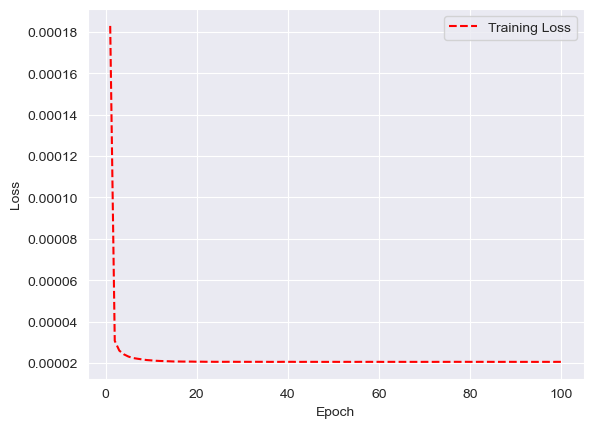

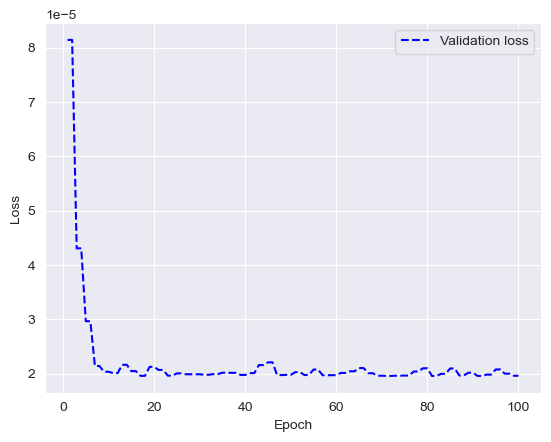

In [11]:
training(model, 100)

Result

In [12]:
path = "./model_state.pt"
model, optimizer, start_epoch, valid_loss_min = load_checkpoint(path, model, optimizer)
print("model = ", model)
print("optimizer = ", optimizer)
print("start_epoch = ", start_epoch)
print("valid_loss_min = ", valid_loss_min)
print("valid_loss_min = {:.6f}".format(valid_loss_min))

model =  LSTM(
  (lstm): LSTM(74, 50, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)
optimizer =  AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.01
)
start_epoch =  82
valid_loss_min =  1.9588802740571223e-05
valid_loss_min = 0.000020
